## TAnoGAN: Time Series Anomaly Detection with Generative Adversarial Networks

Published in: 2020 IEEE Symposium Series on Computational Intelligence (SSCI)

Paper link: https://ieeexplore.ieee.org/abstract/document/9308512

Code was published by Md Abul Bashar and Richi Nayak on https://github.com/mdabashar/TAnoGAN.

### Import required libraries

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
from nab_dataset import NabDataset
from models.recurrent_models_pyramid import LSTMGenerator, LSTMDiscriminator

/Users/anastasiasinitsyna/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/anastasiasinitsyna/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b)
  Referenced from: '/Users/anastasiasinitsyna/anaconda3/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/anastasiasinitsyna/anaconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Define Basic Settings for Adversarial Training

In [2]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=20
    lr=0.0002
    cuda = True
    manualSeed=2
    
opt_trn=ArgsTrn()

In [3]:
torch.manual_seed(opt_trn.manualSeed)
cudnn.benchmark = True

### Setup Data Loader

In [9]:
# location of datasets and category

end_name = 'art_increase_spike_density.csv' # dataset name
data_file = 'data/artificialWithAnomaly/'+end_name # dataset category and dataset name
key = 'artificialWithAnomaly/'+end_name # This key is used for reading anomaly labels

In [10]:
# settings for data loader
class DataSettings:
    
    def __init__(self):
        self.BASE = '/Users/anastasiasinitsyna/Desktop/GIT/TAnoGAN-master/NabDataset/' #'D:\\ResearchDataGtx1060\\AnomalyDetectionData\\NabDataset\\'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = True
        self.window_length = 60
    
    
data_settings = DataSettings()

In [11]:
# define dataset object and data loader object for NAB dataset
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

dataset.x.shape, dataset.y.shape # check the dataset shape

(torch.Size([3972, 60, 1]), torch.Size([3972]))

### Setup Models

In [12]:
#device = torch.device("cuda:0" if opt_trn.cuda else "cpu") # select the device
device = torch.device("cpu")
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature

In [13]:
# Create generator and discriminator models
netD = LSTMDiscriminator(in_dim=in_dim, device=device).to(device)
netG = LSTMGenerator(in_dim=in_dim, out_dim=in_dim, device=device).to(device)

In [14]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm0): LSTM(1, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [15]:
# Setup loss function
criterion = nn.BCELoss().to(device)

In [16]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt_trn.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt_trn.lr)

### Adversarial Training of Generator and Discriminator Models

In [17]:
real_label = 1
fake_label = 0

for epoch in range(opt_trn.epochs):
    for i, (x,y) in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output,_ = netD.forward(real)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()
        
        #Train with fake data
        #noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
        fake,_ = netG.forward(noise)
        output,_ = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        #noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
        fake,_ = netG.forward(noise)
        label.fill_(real_label) 
        output,_ = netD.forward(fake)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()
        
        

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
          % (epoch, opt_trn.epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    print()

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_1214/824483183.py:25: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_1214/824483183.py:40: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1))


[0/20][124/125] Loss_D: 1.5155 Loss_G: 0.4505 D(x): 0.6211 D(G(z)): 0.6422 / 0.6391
[1/20][124/125] Loss_D: 0.8054 Loss_G: 0.6964 D(x): 0.9080 D(G(z)): 0.5003 / 0.4989
[2/20][124/125] Loss_D: 1.6024 Loss_G: 0.6392 D(x): 0.4349 D(G(z)): 0.5311 / 0.5311
[3/20][124/125] Loss_D: 1.4687 Loss_G: 0.5895 D(x): 0.5195 D(G(z)): 0.5555 / 0.5555
[4/20][124/125] Loss_D: 1.3752 Loss_G: 0.5383 D(x): 0.6108 D(G(z)): 0.5844 / 0.5846
[5/20][124/125] Loss_D: 0.3388 Loss_G: 2.0513 D(x): 0.8888 D(G(z)): 0.1696 / 0.1687
[6/20][124/125] Loss_D: 1.6995 Loss_G: 0.4001 D(x): 0.5629 D(G(z)): 0.6727 / 0.6718
[7/20][124/125] Loss_D: 1.4962 Loss_G: 0.5103 D(x): 0.5623 D(G(z)): 0.6008 / 0.6006
[8/20][124/125] Loss_D: 1.4013 Loss_G: 0.5693 D(x): 0.5686 D(G(z)): 0.5663 / 0.5661
[9/20][124/125] Loss_D: 1.2812 Loss_G: 0.6550 D(x): 0.5823 D(G(z)): 0.5209 / 0.5206
[10/20][124/125] Loss_D: 1.0256 Loss_G: 0.8962 D(x): 0.6471 D(G(z)): 0.4244 / 0.4244
[11/20][124/125] Loss_D: 1.4669 Loss_G: 0.4316 D(x): 0.6655 D(G(z)): 0.6496

## Anomaly Detection

#### Define basic settings for inverse mapping

In [18]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()    

In [19]:
generator = netG # changing reference variable 
discriminator = netD # changing reference variable 

##### Define Test Data

In [20]:
# Define settings for loading data in evaluation mood
class TestDataSettings:
    
    def __init__(self):
        self.BASE = '/Users/anastasiasinitsyna/Desktop/GIT/TAnoGAN-master/NabDataset/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = False

        
test_data_settings = TestDataSettings()


In [21]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape

(torch.Size([67, 60, 1]), torch.Size([67]), 67)

#### Define a function to calculate anomaly score

In [22]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

### Inverse mapping to latent space and reconstruction of data for estimating anomaly score

In [23]:
loss_list = []
y_list = []
for i, (x,y) in enumerate(test_dataloader):
    print(i, y)
    
    z = Variable(init.normal(torch.zeros(opt_test.batch_size,
                                     test_dataset.window_length, 
                                     test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    z_optimizer = torch.optim.Adam([z],lr=1e-2)
    
    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = generator(z)
        #gen_fake,_ = generator(z.cuda())
        loss = Anomaly_score(Variable(x), gen_fake)
        #loss = Anomaly_score(Variable(x).cuda(), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break

0 tensor([0.])


/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_1214/2477469716.py:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(opt_test.batch_size,


~~~~~~~~loss=256.39776611328125,  y=tensor([0.]) ~~~~~~~~~~
1 tensor([0.])
~~~~~~~~loss=85.82067108154297,  y=tensor([0.]) ~~~~~~~~~~
2 tensor([0.])
~~~~~~~~loss=3.3033108711242676,  y=tensor([0.]) ~~~~~~~~~~
3 tensor([0.])
~~~~~~~~loss=172.29348754882812,  y=tensor([0.]) ~~~~~~~~~~
4 tensor([0.])
~~~~~~~~loss=3.311403274536133,  y=tensor([0.]) ~~~~~~~~~~
5 tensor([0.])
~~~~~~~~loss=256.38531494140625,  y=tensor([0.]) ~~~~~~~~~~
6 tensor([0.])
~~~~~~~~loss=85.82609558105469,  y=tensor([0.]) ~~~~~~~~~~
7 tensor([0.])
~~~~~~~~loss=3.285417079925537,  y=tensor([0.]) ~~~~~~~~~~
8 tensor([0.])
~~~~~~~~loss=172.3017120361328,  y=tensor([0.]) ~~~~~~~~~~
9 tensor([0.])
~~~~~~~~loss=3.295980453491211,  y=tensor([0.]) ~~~~~~~~~~
10 tensor([0.])
~~~~~~~~loss=256.3948974609375,  y=tensor([0.]) ~~~~~~~~~~
11 tensor([0.])
~~~~~~~~loss=85.84868621826172,  y=tensor([0.]) ~~~~~~~~~~
12 tensor([0.])
~~~~~~~~loss=3.2948293685913086,  y=tensor([0.]) ~~~~~~~~~~
13 tensor([0.])
~~~~~~~~loss=172.295593261718

### Visualise Anomaly Detection

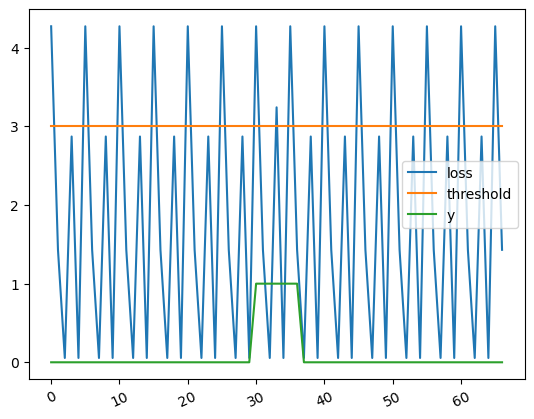

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 3 # Anomaly score threshold for an instance to be considered as anomaly 

#TIME_STEPS = dataset.window_length
test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

### Calculate the window-based anomalies

In [28]:
import numpy as np
start_end = []
state = 0
for idx in test_score_df.index:
    if state==0 and test_score_df.loc[idx, 'y']==1:
        state=1
        start = idx
    if state==1 and test_score_df.loc[idx, 'y']==0:
        state = 0
        end = idx
        start_end.append((start, end))

for s_e in start_end:
    if sum(test_score_df[s_e[0]:s_e[1]+1]['anomaly'])>0:
        for i in range(s_e[0], s_e[1]+1):
            test_score_df.loc[i, 'anomaly'] = 1
            
actual = np.array(test_score_df['y'])
predicted = np.array([int(a) for a in test_score_df['anomaly']])

### Calculate measurement scores

In [29]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

tp = np.count_nonzero(predicted * actual)
tn = np.count_nonzero((predicted - 1) * (actual - 1))
fp = np.count_nonzero(predicted * (actual - 1))
fn = np.count_nonzero((predicted - 1) * actual)

print('True Positive\t', tp)
print('True Negative\t', tn)
print('False Positive\t', fp)
print('False Negative\t', fn)

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = (2 * precision * recall) / (precision + recall)
cohen_kappa_score = cohen_kappa_score(predicted, actual)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(actual, predicted)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f-measure\t', fmeasure)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

True Positive	 7
True Negative	 47
False Positive	 13
False Negative	 0
Accuracy	 0.8059701492537313
Precision	 0.35
Recall	 1.0
f-measure	 0.5185185185185185
cohen_kappa_score	 0.4303466317854806
auc	 0.8916666666666666
roc_auc	 0.8916666666666666
